<h1 style="margin-bottom: 0px;">BooLEVARD: Boolean Logical Evaluation of Activation and Repression in Directed pathways</h1>
<h5 style="margin-bottom: 2px; margin-top: 0px;">Marco Fariñas<sup>1</sup>, Eirini Tsirvouli<sup>2,3</sup>, John Zobolas<sup>4</sup>, Tero Aittokallio<sup>4,5</sup>, Åsmund Flobak<sup>3,6,7</sup>, Kaisa Lehti<sup>1,8</sup></h5>
<h5 style="margin-top: 3px; margin-bottom: 0px;">doi: </h5>
<p style="font-size:small"> 
    <sup>1</sup>. Department of Biomedical Laboratory Science, Norwegian University of Science and Technology (NTNU), Trondheim, Norway. <br>
    <sup>2</sup>. Department of Biology, Norwegian University of Science and Technology (NTNU), Trondheim, Norway.<br>
    <sup>3</sup>. Department of Clinical and Molecular Medicine, Norwegian University of Science and Technology (NTNU), Trondheim, Norway.<br>
    <sup>4</sup>. Department of Cancer Genomics, Oslo University Hospital (OUH), Oslo, Norway.<br>
    <sup>5</sup>. Institute for Molecular Medicine Finland, University of Helsinki, Helsinki, Finland.<br>
    <sup>6</sup>. The Cancer Clinic, St. Olavs Hospital, Trondheim, Norway.<br>
    <sup>7</sup>. Department of Biotechnology and Nanomedicine, Sintef Industry, Trondheim, Norway.<br>
    <sup>8</sup>. Department of Microbiology, Tumor and Cell Biology, Karolinska Institute (KI), Stockholm, Sweden.<br>
</p>
<h4 style="margin-top: 0px; margin-bottom: 2px; font-size: 1.5em"><b>Use Case 1: Boolean Model Processing with BooLEVARD</b></h4>

In this notebook, we present a workflow for processing Boolean models available in Cell Collective using BooLEVARD. The pipeline involves the following steps:

1. **Importing** a model in *SBML-qual* format (Cell Collective default).
2. **Converting** the model to *BoolNet* format (BooLEVARD's input).
3. **Loading** the model into **BooLEVARD** to compute path-count-based transduction scores toward every non-input node within the model.
4. **Extracting** stable state analysis results to determine the binary activation state (0 or 1) of the non-input nodes within the model.

In addition to the transduction scores and stable states, we provide metadata for each example, including:
- Total numbber of nodes,
- Number of computed *stable states*,
- Total count of *activating and inhibitory paths*.
- And the *runtime* required for each computation step.

We apply this workflow to six publicly available Boolean models from Cell Collective:

- **T Cell Receptor Signaling**
- **Guard Cell Abscisic Acid Signaling**
- **T-LGL Survival Network**
- **Bortezomib Responses in U266 Human Myeloma Cells**
- **MAPK Cancer Cell Fate Network**

This use case illustrates how mechanistic information encoded in the Boolean equations (captured by transduction path counts) can be systematically compared with the emergent behavior of the system derived from its stable states.

<h4 style="margin-top: 0px; margin-bottom: 2px;" id="section-0"><b>0.- Package load</b></h4>

In [1]:
import biolqm
import tempfile
import time
import re
import mpbn
import contextlib
import io
import xml.etree.ElementTree as ET
import boolevard as blv
import pandas as pd
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
from PyComplexHeatmap import * 
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from scipy.cluster.hierarchy import linkage, leaves_list
from sklearn.metrics import r2_score
from matplotlib.ticker import LogLocator, NullFormatter

/home/marco/.local/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


/home/marco/.local/lib/python3.11/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


<h4 style="margin-top: 0px; margin-bottom: 2px;" id="section-1"><b>1.- Functions</b></h4>

In [2]:
# Extract qualitative species IDs and names from SBML-qual file
def extract_qualids(sbml_file):
    ns = {"qual": "http://www.sbml.org/sbml/level3/version1/qual/version1"}
    tree = ET.parse(sbml_file)
    root = tree.getroot()
    id2name = {}
    for q in root.findall(".//qual:qualitativeSpecies", ns):
        qid = q.attrib.get("{http://www.sbml.org/sbml/level3/version1/qual/version1}id")
        name = q.attrib.get("{http://www.sbml.org/sbml/level3/version1/qual/version1}name", qid)
        if qid and name:
            id2name[qid] = name
    return id2name

# Convert SBML-qual model to bnet format
def sbml2bnet(sbml_file, output_file):
    try:
        model = biolqm.load(sbml_file)
        id2name = extract_qualids(sbml_file)
        with tempfile.NamedTemporaryFile("w+", delete=False, suffix=".bnet") as f:
            biolqm.save(model, f.name, "bnet")
            f.seek(0)
            lines = f.readlines()
        new_lines = []
        id_pattern = re.compile(r'\b({})\b'.format('|'.join(map(re.escape, id2name.keys()))))
        for line in lines:
            if line.startswith("#") or "," not in line:
                new_lines.append(line)
                continue
            target, expr = map(str.strip, line.split(",", 1))
            target = id2name.get(target, target).replace(",", "_").replace("/", "_").replace("+", "").replace("-", "__").replace("(", "").replace(")", "")
            expr = id_pattern.sub(lambda m: id2name[m.group(0)], expr)
            expr = expr.replace("&", " & ").replace("/", "_").replace(",", "_").replace("+", "").replace("-", "__").replace("(", "").replace(")", "")
            new_lines.append(f"{target}, {expr}\n")
        with open(output_file, "w") as out:
            out.writelines(new_lines)
        print(f"✅ SBML-qual model successfully converted to bnet: {output_file}")
    except Exception as e:
        print(f"❌ Error: {e}")

# Get simulation times
def simmulation_summary(model, pc):
    n_paths = np.abs(pc).sum()
    n_nodes = len(model.Nodes)
    n_inputs = len(model.Info.index[model.Info.index == model.Info["DNF"].apply(str)])
    n_stable_states = len(pc)
    avg_stime_ss = sim_time / n_stable_states
    avg_stime_node = sim_time / n_stable_states / n_nodes
    avg_stime_path = sim_time / n_paths
    sum = pd.DataFrame([{
        "Simulation time (s)": sim_time,
        "Stable states": n_stable_states,
        "Nodes": n_nodes,
        "Inputs": n_inputs,
        "Paths": n_paths,
        "Avg time / state (s)": avg_stime_ss,
        "Avg time / node (s)": avg_stime_node,
        "Avg time / path (s)": avg_stime_path
    }])
    return sum

# Perform analysis using BooLEVARD
def Report(model, paths, base = 4):
    def log_signed(x, base):
        return np.sign(x) * np.log1p(np.abs(x)) / np.log(base)
    inputs = model.Info.index[model.Info.index == model.Info["DNF"].apply(str)]
    # Transduction:
    paths_sum = pd.DataFrame(paths)
    paths_sum.columns = nodes
    paths_sum = paths_sum.loc[:, ~paths_sum.columns.isin(inputs)]
    paths_sum = log_signed(paths_sum, base)
    # Local states:
    ls_info = model.Info.loc[nodes, model.Info.columns[:-2]].transpose()
    ls_info = ls_info.loc[:, ~ls_info.columns.isin(inputs)]
    ls_info.index = paths_sum.index
    ### Plot heatmap ###
    row_linkage = linkage(paths_sum.values, method="average", metric="euclidean")
    col_linkage = linkage(paths_sum.values.T, method="average", metric="euclidean")
    row_order = leaves_list(row_linkage)
    col_order = leaves_list(col_linkage)
    row_labels = paths_sum.index[row_order]
    col_labels = paths_sum.columns[col_order]
    paths_sum = paths_sum.loc[row_labels, col_labels]
    ls_info = ls_info.loc[row_labels, col_labels]

    colors_row_ha = {input_name: {"0": "#eeeeee", "1": "#212121"} for input_name in inputs}
    # Annotations
    annot_ls = pd.DataFrame(["Local State"]*(len(nodes)-len(inputs)), columns = ["Score"])
    annot_paths = pd.DataFrame(["Path Count"]*(len(nodes)-len(inputs)), columns = ["Score"])
    annot_inputs = model.Info.loc[inputs, model.Info.columns[:-2]].transpose().astype(str)
    annot_inputs.index = paths_sum.index
    row_ha_inputs = HeatmapAnnotation(df = annot_inputs, colors = colors_row_ha, plot = False, legend = False, axis = 0, label_kws = dict(size = 9), label_side = "bottom", wgap = 0.01, plot_kws = dict(linewidth = 0.001, linecolor = "white", linestyle = ":"), legend_width=90) # Annotation for inputs
    # - Subheatmap 1: Local States
    cmap_ls = ListedColormap(["#eeeeee", "#212121"])
    hmap_ls = ClusterMapPlotter(
        ls_info.astype(int),
        row_cluster = False, col_cluster = False,
        show_rownames = True, show_colnames = True,
        cmap = cmap_ls, linewidths = 0.001, linecolor = "white",
        plot = False,
        plot_legend = True, label = "Local States",
        left_annotation = row_ha_inputs,
        xlabel = "Local States",
        xlabel_kws=dict(color='black',fontsize = 10,labelpad=7, x = 1, ha = "center"),
        xticklabels_kws=dict(size=1),
        xlabel_side='top'
    )
    # - Subheatmap 2: Path Count
    cmap_paths = LinearSegmentedColormap.from_list("custom_diverging", ["#696bd4", "#FFFFFF", "#e55451"], N = 256)
    vmax_paths = np.max(np.abs(paths_sum.values))
    hmap_paths = ClusterMapPlotter(
        paths_sum,
        row_cluster = False, col_cluster = False,
        show_rownames = True, show_colnames = True,
        left_annotation = row_ha_inputs,
        cmap = cmap_paths, vmin = -vmax_paths, vmax = vmax_paths,
        linewidths = 0.001, linecolor = "white",
        plot = False,
        plot_legend = True, label = "LogPC",
        xlabel = "Log-PathCounts",
        xlabel_kws=dict(color='black',fontsize=10,labelpad=7, x = 1, ha = "center"),
        xlabel_side='top'
    )
    return[hmap_ls, hmap_paths]

<h4 style="margin-top: 0px; margin-bottom: 2px;" id="section-2"><b>2.- Set inputs/outputs</b></h4>

In [3]:
# Conversion from SBML to BoolNet

# BoolNet and SBML directories
sbml_dir = "models/sbml/"
bnet_dir = "models/bnet/"

# Models #
models_repo = [
    "T Cell Receptor Signaling (SBML)",
    "Guard Cell Abscisic Acid Signaling (SBML)",
    "T-LGL Survival Network 2011 (SBML)",
    "HGF Signaling in Keratinocytes (SBML)",
    "_Bortezomib Responses in U266 Human Myeloma Cells (SBML)",
    "MAPK Cancer Cell Fate Network (SBML)"
]

<h4 style="margin-top: 0px; margin-bottom: 2px;" id="section-3.1"><b>3.- Cell Collective Boolean Models</b></h4>
<h5 style="margin-top: 20px; margin-bottom: 2px;" id="section-3.1"><b>3.1.- T Cell Receptor Signaling</b></h5>
<p>
This model represents the activation of primary T lymphocytes, key regulators of the adaptive immune response. Unlike many existing models, which are often based on data from transformed T cell lines, this network was constructed integrating experimental findings specifically from non-transformed, primary T cells. The model captures key signaling events triggered by the engagement of the T Cell Receptor (TCR), CD4/CD8 co-receptors, and the co-stimulatory molecule CD28. Therefore, it enables the in silico exploration of T cell activation pathways and was used to uncover non-obvious signaling routes, such asthose involving CD28 and the kinase Fyn. 
</p>
<p style="font-size:90%; color:gray;">
Saez-Rodriguez J, Simeoni L, Lindquist JA, Hemenway R, Bommhardt U, et al. (2007).  
<i>A Logical Model Provides Insights into T Cell Receptor Signaling.</i>  
PLOS Computational Biology 3(8): e163.  
<a href="https://doi.org/10.1371/journal.pcbi.0030163" target="_blank">https://doi.org/10.1371/journal.pcbi.0030163</a>
</p>

In [4]:
# Run analysis
# Select model and convert SBML to BoolNet format
model_name = models_repo[0]
model_path = f"{bnet_dir}{model_name}.bnet"
sbml2bnet((f"{sbml_dir}{model_name}.sbml"), (f"{bnet_dir}{model_name}.bnet"))
# Load the BoolNet model, extract nodes and count paths
model = blv.Load(model_path)
nodes = model.Nodes
start_time = time.time()
pc = model.CountPaths(nodes, ss_wise = True)
end_time = time.time()
sim_time = end_time - start_time
ls, paths = Report(model, pc) # ls will contain stable state analysis results and paths will contain BooLEVARD's results


✅ SBML-qual model successfully converted to bnet: models/bnet/T Cell Receptor Signaling (SBML).bnet
Evaluating Stable State: 38
pip3: -4, 1.7364819844563802e-06 minutes.
pten: -1, 3.933906555175781e-07 minutes.
fos: -347, 7.033348083496094e-06 minutes.
fkhr: 4, 2.2252400716145834e-07 minutes.
plcgb: -31, 5.602836608886719e-07 minutes.
p38: -31, 5.80151875813802e-07 minutes.
fyn: -12, 1.3113021850585939e-07 minutes.
calpr1: -1, 1.6689300537109374e-07 minutes.
bclxl: -4, 1.9470850626627604e-07 minutes.
ikkab: -734, 9.397665659586588e-06 minutes.
ccblr: -1, 1.5497207641601563e-07 minutes.
unknown_input3: 0, 1.231829325358073e-07 minutes.
ca: -316, 4.128615061442057e-06 minutes.
bcat: -4, 3.6557515462239586e-07 minutes.
Dummy: -316, 4.15643056233724e-06 minutes.
cre: -347, 4.251797993977864e-06 minutes.
hpk1: -31, 5.205472310384114e-07 minutes.
ip3: -316, 3.7829081217447918e-06 minutes.
ikkg: -418, 4.871686299641927e-06 minutes.
ap1: -664, 9.008248647054036e-06 minutes.
bad: 4, 2.026557922

Simulation time (s),Stable states,Nodes,Inputs,Paths,Avg time / state (s),Avg time / node (s),Avg time / path (s)
15.809348,104,101,7,490156,0.152013,0.001505,0.000032


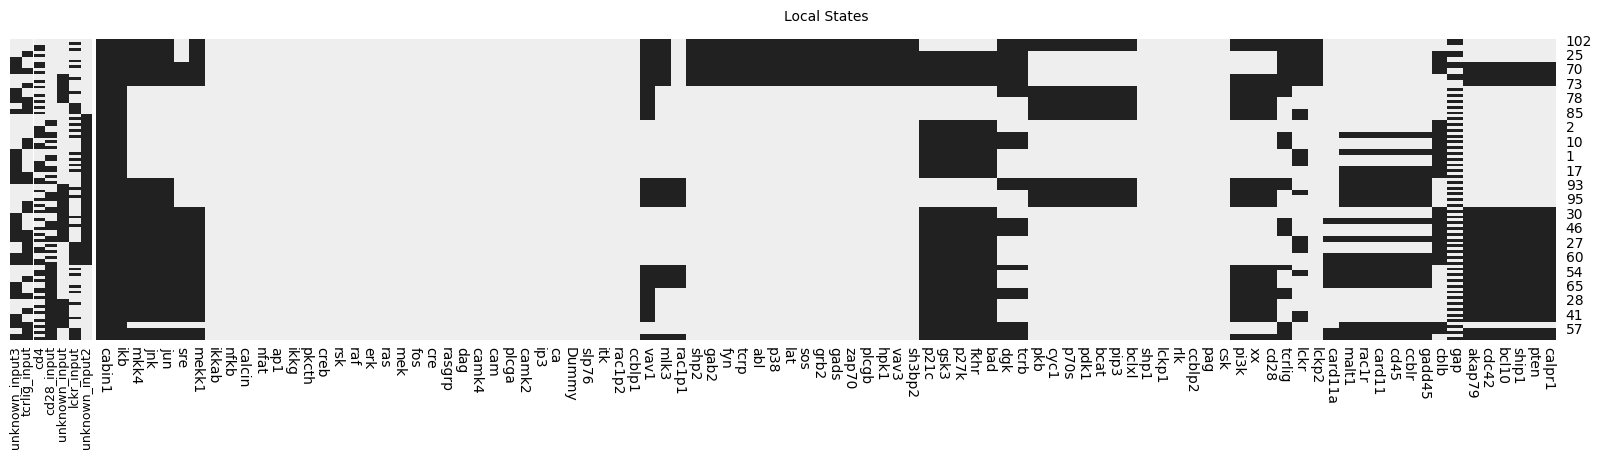

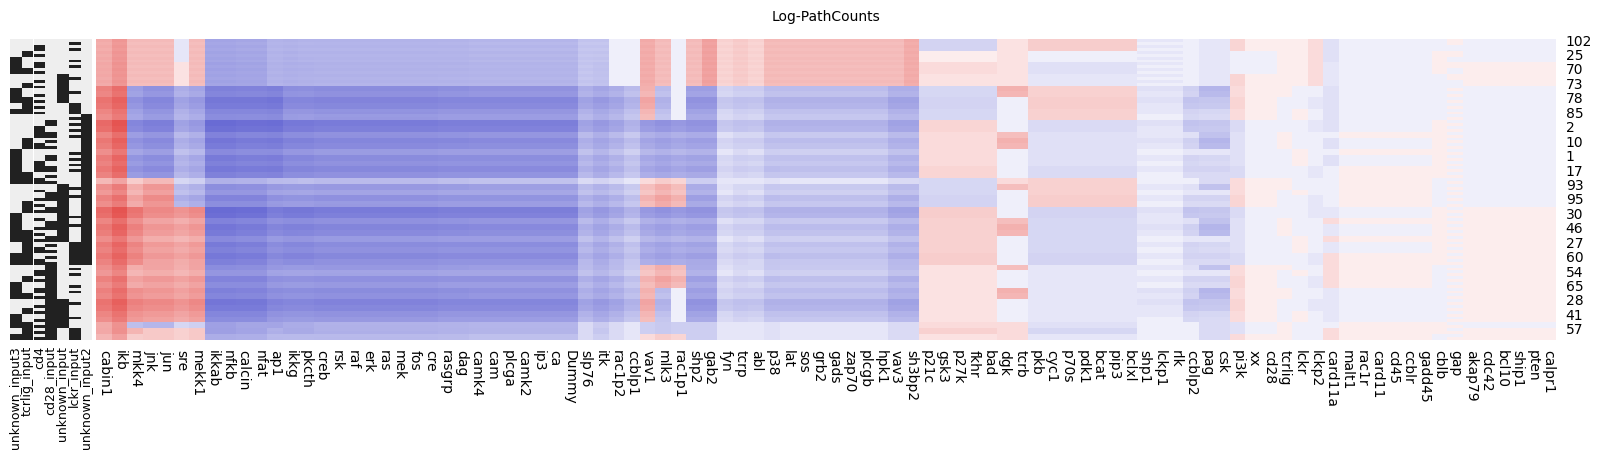

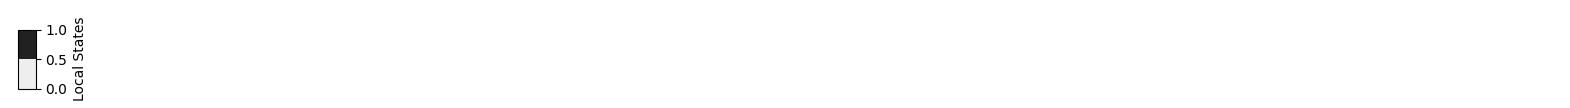

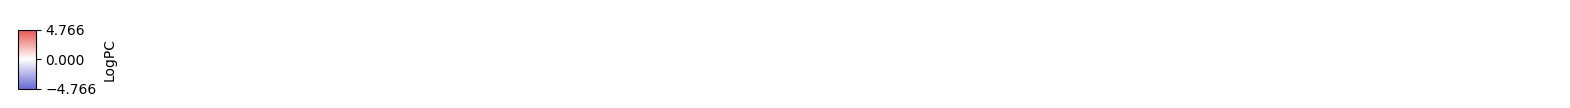

In [5]:
# Plot Report
sim_sum1 = simmulation_summary(model, pc)
display(sim_sum1.style.hide(axis = "index"))
with contextlib.redirect_stdout(io.StringIO()):
    plt.figure(figsize=(20, 4)); ls.plot()
    plt.figure(figsize=(20, 4)); paths.plot()
    plt.figure(figsize=(20, 1)); ls.plot_legends()
    plt.figure(figsize=(20, 1)); paths.plot_legends()

<div style="font-size:90%;">

**Figure 1.** Heatmaps showing the Boolean states (top) and the corresponding transduction path counts (bottom), calculated using BooLEVARD, for the stable states reached by the T Cell Receptor Signaling Boolean model. The Boolean activation states of the input nodes (*unknown_input3*, *tcrlig_input*, *cd28_input*, *unknown_input*, *lckr_input*, and *unknown_input*) that drive each stable state are shown to the left of both heatmaps (black = ON, white = OFF). Path counts are shown on a signed logarithmic scale (Log₄ of the number of activating or inhibitory paths). Red indicates a high number of activating paths toward a node; blue indicates inhibitory paths. Rows (stable states) and columns (nodes) have been clustered using Euclidean distance to highlight patterns across conditions and model components.

</div>

In the present and following examples, this visualization highlights the additional layer of information provided by **BooLEVARD** beyond the binary output of stable state analysis. Within each individual state, we can observe differences in the number of activating and inhibitory paths converging onto each node. These differences reflect both the topological positioning of each node (i.e. how upstream or downstream it is within the network) and the structural redundancy of the signaling routes that lead to its activation or repression. Moreover, by comparing across stable states, we can identify cases where different input combinations lead to identical binary states for certain nodes, yet exhibit marked differences in their transduction path profiles. Such cases may indicate nodes that are **functionally stable but topologically variable**, revealing hidden dependencies or alternative pathways that are not apparent from Boolean outputs alone. This enables a richer understanding of signal integration and robustness within the network.

<h5 style="margin-top: 00px; margin-bottom: 2px;" id="section-3.2"><b>3.2.- Guard Cell Abscisic Acid</b></h5>
<p>

This model describes the signaling network underlying **ABA-induced stomatal closure** in plant guard cells. Stomata are microscopic pores on th leaf surface that regulate gas exchange, and their aperture is tightly controlled by a pair of guard cells. In response to drought, the hormone abscisic acid (ABA) promotes stomatal closure to minimize water loss. This complex physiological response involves a broad aarray of molecular components, including ion channels, secondary messengers, and cytoskeletal regulators. The model integrates more than 40 experimetally characterized components into a unified **signal transduction network** that captures the main regulatory interactions driving guard cell shrinkage and stomatal closure. It successfully reproduces known physiological and pathway-level respones to ABA.

</p>
<p style="font-size:90%; color:gray;">
Li S, Assmann SM, Albert R (2006).  
<i>Predicting Essential Components of Signal Transduction Networks: A Dynamic Model of Guard Cell Abscisic Acid Signaling.</i>  
PLOS Biology 4(10): e312.  
<a href="https://doi.org/10.1371/journal.pbio.0040312" target="_blank">https://doi.org/10.1371/journal.pbio.0040312</a>
</p>


In [6]:
# Run analysis
# Select model and convert SBML to BoolNet format
model_name = models_repo[1]
model_path = f"{bnet_dir}{model_name}.bnet"
sbml2bnet((f"{sbml_dir}{model_name}.sbml"), (f"{bnet_dir}{model_name}.bnet"))
# Load the BoolNet model, extract nodes and count paths
model = blv.Load(model_path)
nodes = model.Nodes
start_time = time.time()
pc = model.CountPaths(nodes, ss_wise = True)
end_time = time.time()
sim_time = end_time - start_time
ls, paths = Report(model, pc) # ls will contain stable state analysis results and paths will contain BooLEVARD's results

✅ SBML-qual model successfully converted to bnet: models/bnet/Guard Cell Abscisic Acid Signaling (SBML).bnet
Evaluating Stable State: 8
ABA: 0, 8.026758829752604e-07 minutes.
KEV: -2, 2.0424524943033854e-06 minutes.
KAP: 4, 6.318092346191406e-07 minutes.
Closure: -2, 4.1325887044270835e-07 minutes.
NIA12: 1, 2.582867940266927e-07 minutes.
CaIM: -2, 3.973642985026042e-07 minutes.
PLD: 0, 1.7484029134114582e-07 minutes.
AnionEM: -2, 1.9073486328125e-07 minutes.
ROP10: -1, 2.90075937906901e-07 minutes.
NO: -2, 3.616015116373698e-07 minutes.
S1P: 1, 1.5497207641601563e-07 minutes.
ABH1: 0, 1.2715657552083333e-07 minutes.
GPA1: 0, 3.178914388020833e-08 minutes.
ROP2: 0, 1.629193623860677e-07 minutes.
InsP3: -2, 3.0597050984700523e-07 minutes.
SphK: 1, 1.5497207641601563e-07 minutes.
NOS: -2, 3.0199686686197915e-07 minutes.
Atrboh: -1, 7.549921671549479e-08 minutes.
Ca2_ATPase: -2, 3.0994415283203126e-07 minutes.
OST1: 1, 1.4702479044596355e-07 minutes.
Malate: -2, 1.7881393432617188e-07 min

Simulation time (s),Stable states,Nodes,Inputs,Paths,Avg time / state (s),Avg time / node (s),Avg time / path (s)
0.556040,16,44,4,2374,0.034752,0.000790,0.000234


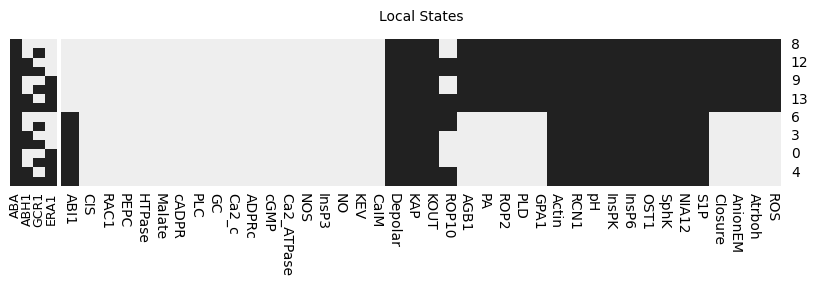

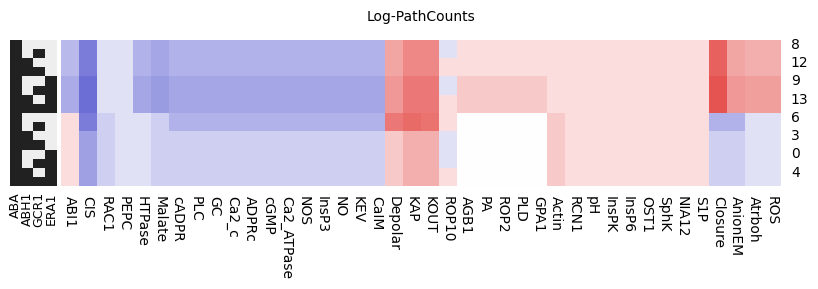

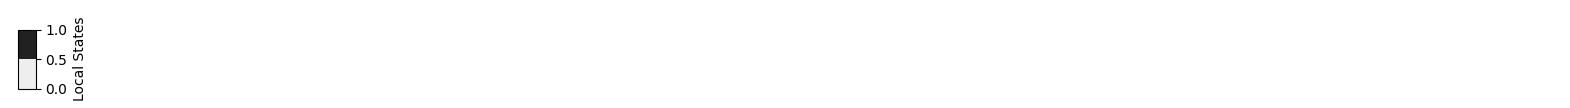

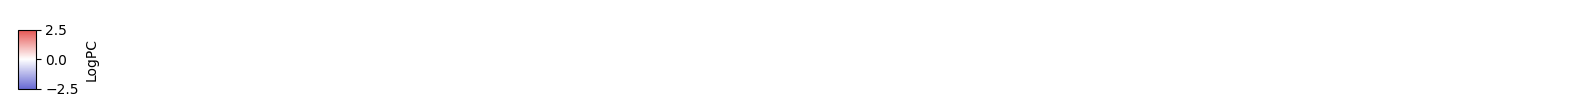

In [7]:
# Plot Report
sim_sum2 = simmulation_summary(model, pc)
display(sim_sum2.style.hide(axis = "index"))
with contextlib.redirect_stdout(io.StringIO()):
    plt.figure(figsize=(10, 2)); ls.plot()
    plt.figure(figsize=(10, 2)); paths.plot()
    plt.figure(figsize=(20, 1)); ls.plot_legends()
    plt.figure(figsize=(20, 1)); paths.plot_legends()

<div style="font-size:90%;">

**Figure 2.** Heatmaps showing the Boolean states (top) and the corresponding transduction path counts (bottom), calculated using BooLEVARD, for the stable states reached by the Guard Cell Ascibic Acid Boolean model. The Boolean activation states of the input nodes (*ABA*, *ABH1*, *GCR1* and *ERA1*) that drive each stable state are shown to the left of both heatmaps (black = ON, white = OFF). Path counts are shown on a signed logarithmic scale (Log₄ of the number of activating or inhibitory paths). Red indicates a high number of activating paths toward a node; blue indicates inhibitory paths. Rows (stable states) and columns (nodes) have been clustered using Euclidean distance to highlight patterns across conditions and model components.

</div>

<h5 style="margin-top: 00px; margin-bottom: 2px;" id="section-3.3"><b>3.3.- T-LGL Survival Network</b></h5>
<p>

This model represents the survival signaling network of **T cell large granular lymphocyte (T-LGL) leukemia**, a disease characterized by the clonal expansion of antigen-primed, cytotoxic T lymphocytes (CTL). The model integrates key signaling pathways involved in normal CTL activation and dysregulated survival signals observed in leukemic T-LGL cells. It includes not only molecular components like proteins, mRNAs, and small molecules, but also summary nodes that represent high-level cellular processes such as *Proliferation*, *Apoptosis*, and *Cytoskeleton signaling*. Thediscrete dynamic model provides a framework for identifying potential therapeutic targets in T-LGL leukemia and for exploring mechanisms of long-term CTL survival in both pathological and immunotherapeutic contexts.
<p style="font-size:90%; color:gray;">
Zhang R, Shah MV, Yang J, Nyland SB, Liu X, Yun JK, Albert R, Loughran TP (2008).  
<i>Network Model of Survival Signaling in Large Granular Lymphocyte Leukemia.</i>  
Proceedings of the National Academy of Sciences 105(42): 16308–16313.  
<a href="https://doi.org/10.1073/pnas.0806447105" target="_blank">https://doi.org/10.1073/pnas.0806447105</a>
</p>

In [8]:
# Run analysis
# Select model and convert SBML to BoolNet format
model_name = models_repo[2]
model_path = f"{bnet_dir}{model_name}.bnet"
sbml2bnet((f"{sbml_dir}{model_name}.sbml"), (f"{bnet_dir}{model_name}.bnet"))
# Load the BoolNet model, extract nodes and count paths
model = blv.Load(model_path)
nodes = model.Nodes
start_time = time.time()
pc = model.CountPaths(nodes, ss_wise = True)
end_time = time.time()
sim_time = end_time - start_time
ls, paths = Report(model, pc) # ls will contain stable state analysis results and paths will contain BooLEVARD's results

✅ SBML-qual model successfully converted to bnet: models/bnet/T-LGL Survival Network 2011 (SBML).bnet
Evaluating Stable State: 34
A20: -559, 2.674261728922526e-05 minutes.
TNF: -559, 2.195437749226888e-05 minutes.
MEK: -685, 2.3770332336425782e-05 minutes.
GAP: -1371, 4.7389666239420576e-05 minutes.
S1P: -1, 3.3775965372721356e-07 minutes.
Ceramide: -3449, 0.00012296438217163086 minutes.
CD45: 0, 2.384185791015625e-08 minutes.
SMAD: -1, 5.006790161132813e-07 minutes.
Fas: -3449, 0.000116117795308431 minutes.
TCR: -1, 3.536542256673177e-07 minutes.
PLCG1: -343, 1.3649463653564453e-05 minutes.
TAX: 0, 1.9868214925130207e-08 minutes.
GRB2: -522, 2.0209948221842448e-05 minutes.
sFas: -560, 2.4477640787760418e-05 minutes.
IL2RB: -620, 2.1036465962727865e-05 minutes.
NFKB: -559, 3.8572152455647786e-05 minutes.
GPCR: -1, 3.894170125325521e-07 minutes.
IFNG: -1626, 6.920099258422852e-05 minutes.
GZMB: -4512, 0.00014719168345133464 minutes.
P27: -958, 2.7195612589518228e-05 minutes.
ERK: -1011,

Simulation time (s),Stable states,Nodes,Inputs,Paths,Avg time / state (s),Avg time / node (s),Avg time / path (s)
21.030529,82,60,6,14526681,0.256470,0.004274,0.000001


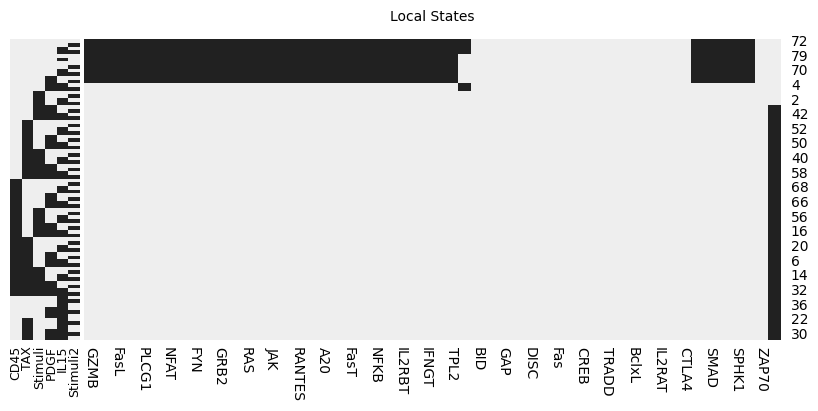

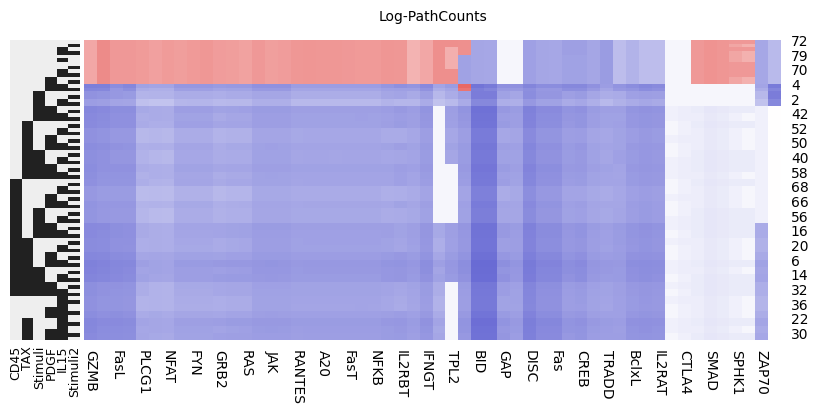

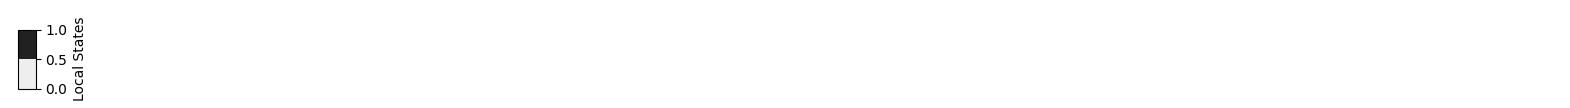

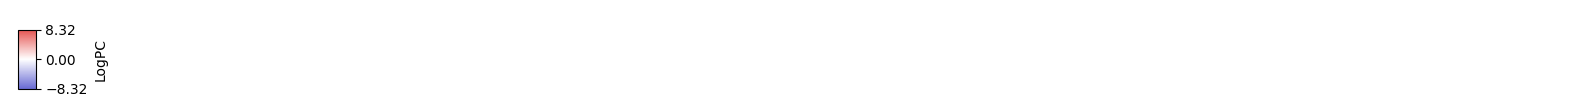

In [9]:
# Plot Report
sim_sum3 = simmulation_summary(model, pc)
display(sim_sum3.style.hide(axis = "index"))
with contextlib.redirect_stdout(io.StringIO()):
    plt.figure(figsize=(10, 4)); ls.plot()
    plt.figure(figsize=(10, 4)); paths.plot()
    plt.figure(figsize=(20, 1)); ls.plot_legends()
    plt.figure(figsize=(20, 1)); paths.plot_legends()

<div style="font-size:90%;">

**Figure 3.** Heatmaps showing the Boolean states (top) and the corresponding transduction path counts (bottom), calculated using BooLEVARD, for the stable states reached by the T-LGL Survival Network Boolean model. The Boolean activation states of the input nodes (*CD45*, *TAX*, *Stimuli*, *PDGF*, *IL15*, *Stimuli2*) that drive each stable state are shown to the left of both heatmaps (black = ON, white = OFF). Path counts are shown on a signed logarithmic scale (Log₄ of the number of activating or inhibitory paths). Red indicates a high number of activating paths toward a node; blue indicates inhibitory paths. Rows (stable states) and columns (nodes) have been clustered using Euclidean distance to highlight patterns across conditions and model components.

</div>

<h5 style="margin-top: 00px; margin-bottom: 2px;" id="section-3.4"><b>3.4.- HGF Signaling in Keratinocytes</b></h5>
<p>

This model describes the molecular signaling events that govern **HGF-induced migration of human keratinocytes (NHK)**, a key process in wound healing and tissue regeneration. The model integrates multiple layers of regulation, including protein signaling, gene expression, and autocrine feedback loops, to capture the full progression from initial stimulation by hepatocyte growth factor (HGF) to the execution of the migratory phenotype. The networks focuses on the dynamics of MET receptor activation, followed by downstream MAPK/ERK and p38/JNK pathway activation, and later sustained by autocrine signals involving EGF receptor and urokinase-type plasminogen activator receptor. This layered activation captures the time-dependent orchestration of early signaling and late transcriptial responses necessary for sustained migration. To reproduce this dynamic behavior, the model incorporates two distinct time scales:
- A **rapid phase** (0-1h) covering immediate protein phosphorylation events.
- A **delayed phase** (1-3h) encompassing transcriptional regulation and autocrine signaling.

This hybrid Boolean framework bridges transcriptomic data with mechanistic signaling, offering a powerful tool to explore the temporal logic of wound healing and keratinocyte migration.
<p style="font-size:90%; color:gray;">
Singh A, Nascimento JM, Kowar S, Busch H, Boerries M (2012).  
<i>Boolean Approach to Signalling Pathway Modelling in HGF-Induced Keratinocyte Migration.</i>  
Bioinformatics, 28(18): i495–i501.  
<a href="https://doi.org/10.1093/bioinformatics/bts410" target="_blank">https://doi.org/10.1093/bioinformatics/bts410</a>
</p>

In [10]:
# Run analysis
# Select model and convert SBML to BoolNet format
model_name = models_repo[3]
model_path = f"{bnet_dir}{model_name}.bnet"
sbml2bnet((f"{sbml_dir}{model_name}.sbml"), (f"{bnet_dir}{model_name}.bnet"))
# Load the BoolNet model, extract nodes and count paths
model = blv.Load(model_path)
nodes = model.Nodes
start_time = time.time()
pc = model.CountPaths(nodes, ss_wise = True)
end_time = time.time()
sim_time = end_time - start_time
ls, paths = Report(model, pc) # ls will contain stable state analysis results and paths will contain BooLEVARD's results

✅ SBML-qual model successfully converted to bnet: models/bnet/HGF Signaling in Keratinocytes (SBML).bnet
Evaluating Stable State: 53
Ca: -72, 6.822745005289714e-06 minutes.
DUSP1: 0, 1.986821492513021e-07 minutes.
HGF: 0, 1.5894571940104166e-08 minutes.
MLK3: -36, 1.8080075581868489e-06 minutes.
p38: -144, 5.14984130859375e-06 minutes.
Mkk6: -36, 1.708666483561198e-06 minutes.
DOCK180: -97, 3.3736228942871095e-06 minutes.
MET: -1, 1.629193623860677e-07 minutes.
ATF2: -288, 1.1154015858968099e-05 minutes.
Plasmin: -217, 7.502237955729166e-06 minutes.
CCL20: -131, 5.431969960530599e-06 minutes.
Mekk7: -36, 1.712640126546224e-06 minutes.
uPA: -283, 8.916854858398437e-06 minutes.
Grb2: -97, 3.441174825032552e-06 minutes.
ETS: -131, 5.3604443868001304e-06 minutes.
SOS: -97, 3.4769376118977866e-06 minutes.
Raf: -141, 6.171067555745443e-06 minutes.
AP1: -283, 8.73406728108724e-06 minutes.
DAG: -72, 3.3418337504069012e-06 minutes.
cFOS: -131, 5.427996317545573e-06 minutes.
PKC: -144, 5.8571497

Simulation time (s),Stable states,Nodes,Inputs,Paths,Avg time / state (s),Avg time / node (s),Avg time / path (s)
5.929228,72,68,6,303199,0.082350,0.001211,0.000020


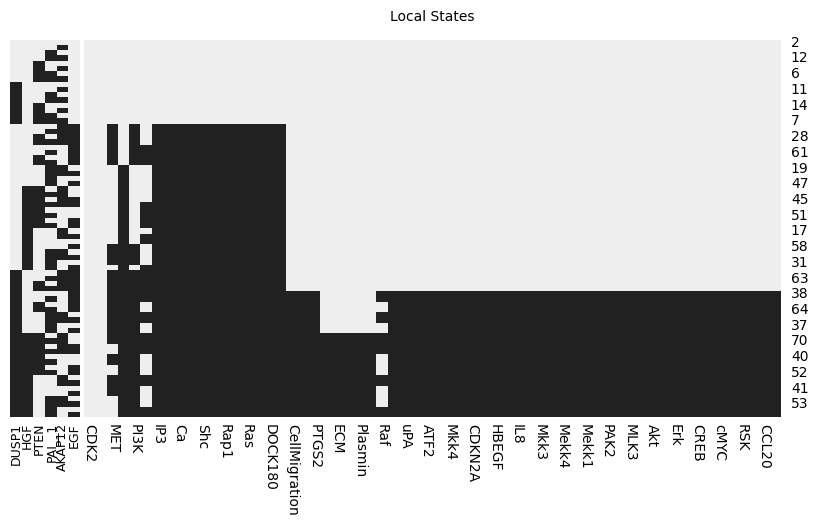

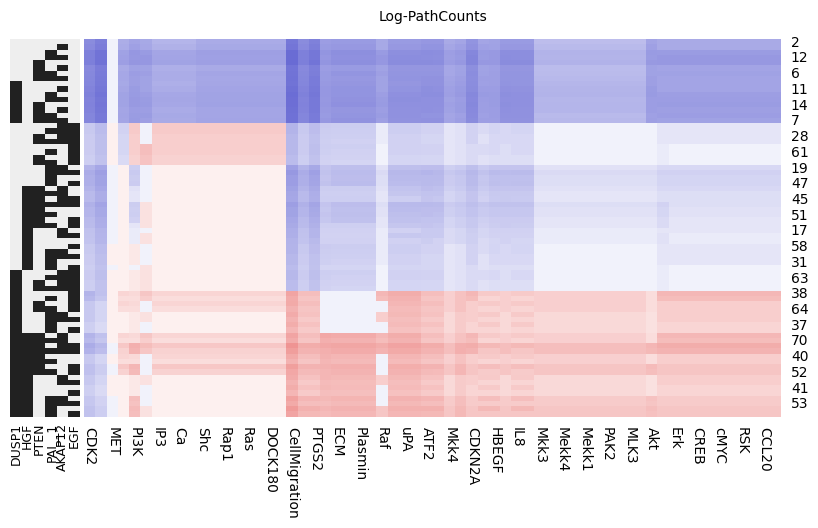

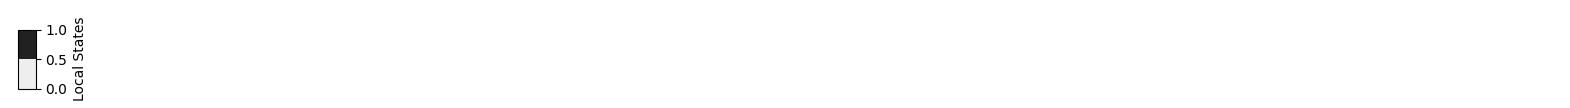

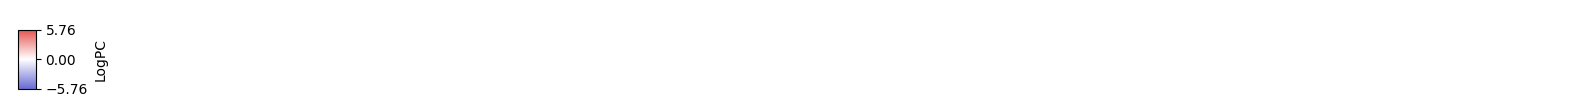

In [11]:
# Plot Report
sim_sum4 = simmulation_summary(model, pc)
display(sim_sum4.style.hide(axis = "index"))
with contextlib.redirect_stdout(io.StringIO()):
    plt.figure(figsize=(10, 5)); ls.plot()
    plt.figure(figsize=(10, 5)); paths.plot()
    plt.figure(figsize=(20, 1)); ls.plot_legends()
    plt.figure(figsize=(20, 1)); paths.plot_legends()

<div style="font-size:90%;">

**Figure 4.** Heatmaps showing the Boolean states (top) and the corresponding transduction path counts (bottom), calculated using BooLEVARD, for the stable states reached by the HGF Signaling in Kertinocytes Boolean model. The Boolean activation states of the input nodes (*DUSP1*, *HGF*, *PTEN*, *PAI_1*, *AKAP12*, *EGF*) that drive each stable state are shown to the left of both heatmaps (black = ON, white = OFF). Path counts are shown on a signed logarithmic scale (Log₄ of the number of activating or inhibitory paths). Red indicates a high number of activating paths toward a node; blue indicates inhibitory paths. Rows (stable states) and columns (nodes) have been clustered using Euclidean distance to highlight patterns across conditions and model components.

</div>

<h5 style="margin-top: 00px; margin-bottom: 2px;" id="section-3.5"><b>3.5.- Bortezomib Responses in U266 Human Myeloma Cells</b></h5>
<p>

This model represents the signaling pathways regulating **cell survival and apoptosis in U266 multiple myeloma (MM) cells**, with a focus on understanding the cytotoxic effects of bortezomib, a proteasome inhibitor used as first-line therapy in MM. The network integrates major signaling axes such as NFkB, JAK/STAT, and Bcl-2 family proteins. The model illustrate how discrete logic-based models can be coupled with drug response dynamics to explore therapeutic mechanisms and rationale discrepancies between expected and observed outcomes.
<p style="font-size:90%; color:gray;">
Chudasama VL, Ovacik MA, Abernethy DR, Mager DE (2015).  
<i>Logic-Based and Cellular Pharmacodynamic Modeling of Bortezomib Responses in U266 Human Myeloma Cells.</i>  
The Journal of Pharmacology and Experimental Therapeutics, 354(3): 448–458.  
<a href="https://doi.org/10.1124/jpet.115.224766" target="_blank">https://doi.org/10.1124/jpet.115.224766</a>
</p>

In [12]:
# Run analysis
# Select model and convert SBML to BoolNet format
model_name = models_repo[4]
model_path = f"{bnet_dir}{model_name}.bnet"
sbml2bnet((f"{sbml_dir}{model_name}.sbml"), (f"{bnet_dir}{model_name}.bnet"))
# Load the BoolNet model, extract nodes and count paths
model = blv.Load(model_path)
nodes = model.Nodes
start_time = time.time()
pc = model.CountPaths(nodes, ss_wise = True)
end_time = time.time()
sim_time = end_time - start_time
ls, paths = Report(model, pc) # ls will contain stable state analysis results and paths will contain BooLEVARD's results

✅ SBML-qual model successfully converted to bnet: models/bnet/_Bortezomib Responses in U266 Human Myeloma Cells (SBML).bnet
Evaluating Stable State: 62
ERK: -9, 2.4398167928059894e-06 minutes.
MKK4: -12, 2.6384989420572916e-06 minutes.
BAD: 1, 1.7484029134114582e-07 minutes.
STAT3: 29, 1.3271967569986979e-06 minutes.
CDK2: -34, 8.702278137207031e-07 minutes.
BID: -25, 1.3907750447591145e-06 minutes.
JAK1: -8, 3.0597050984700523e-07 minutes.
Fas: -15, 7.708867390950521e-07 minutes.
BAX: -35, 1.5377998352050782e-06 minutes.
Cytc: -35, 1.7682711283365886e-06 minutes.
GROWTH: -88, 1.7682711283365886e-06 minutes.
CDK4: -44, 7.907549540201823e-07 minutes.
Smac: -35, 1.7762184143066407e-06 minutes.
Prot: 1, 1.629193623860677e-07 minutes.
XIAP: -24, 5.245208740234375e-07 minutes.
SHP1: 0, 1.5894571940104166e-08 minutes.
JAK2: -8, 2.8212865193684896e-07 minutes.
CIAP: -1, 1.629193623860677e-07 minutes.
STRESS: -12, 5.76178232828776e-07 minutes.
MYC: -34, 5.086263020833333e-07 minutes.
CYCE: -34

Simulation time (s),Stable states,Nodes,Inputs,Paths,Avg time / state (s),Avg time / node (s),Avg time / path (s)
8.477541,83,67,5,1616931,0.102139,0.001524,0.000005


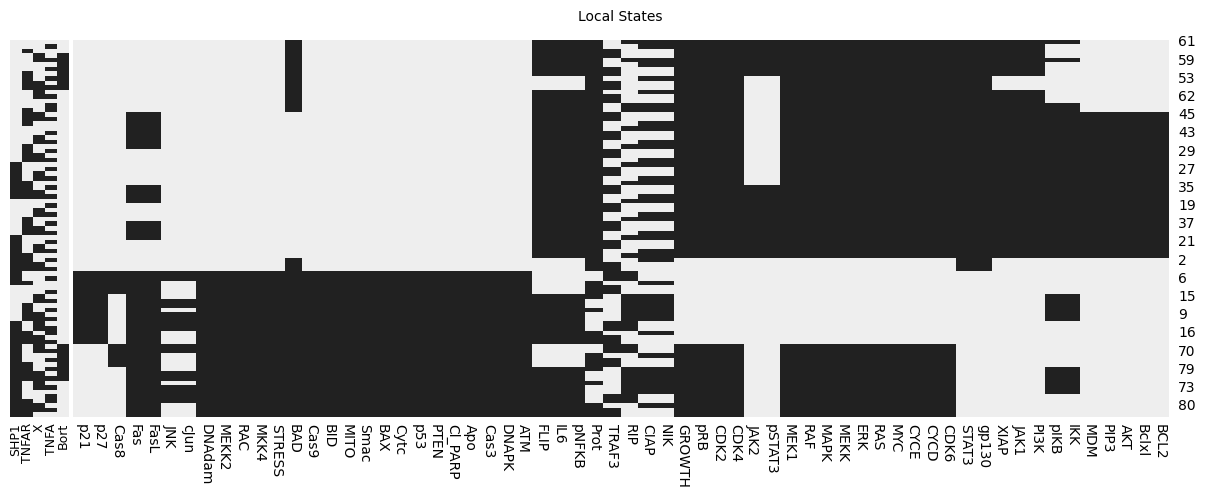

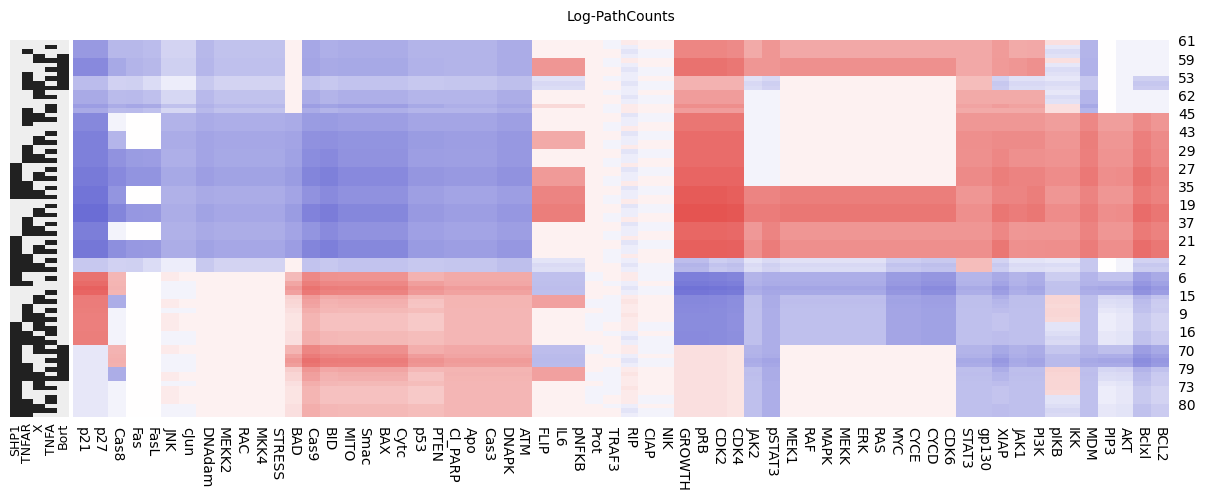

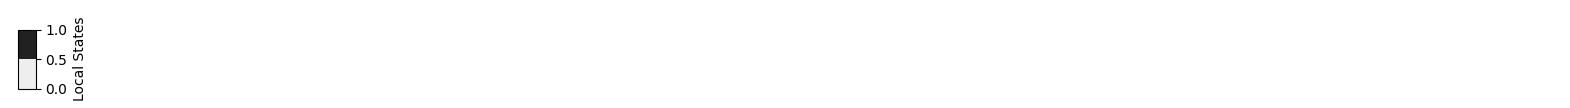

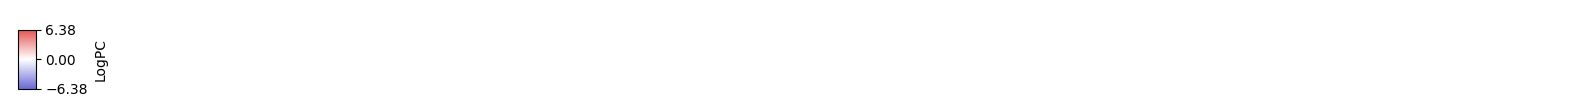

In [13]:
#Plot Report
sim_sum5 = simmulation_summary(model, pc)
display(sim_sum5.style.hide(axis = "index"))
with contextlib.redirect_stdout(io.StringIO()):
    plt.figure(figsize=(15, 5)); ls.plot()
    plt.figure(figsize=(15, 5)); paths.plot()
    plt.figure(figsize=(20, 1)); ls.plot_legends()
    plt.figure(figsize=(20, 1)); paths.plot_legends()

<div style="font-size:90%;">

**Figure 5.** Heatmaps showing the Boolean states (top) and the corresponding transduction path counts (bottom), calculated using BooLEVARD, for the stable states reached by the Bortezomib Responses in U266 Human Myeloma Cells Boolean Model. The Boolean activation states of the input nodes (*SHP1*, *TNFAR*, *X*, *TNFA*, *Bort*) that drive each stable state are shown to the left of both heatmaps (black = ON, white = OFF). Path counts are shown on a signed logarithmic scale (Log₄ of the number of activating or inhibitory paths). Red indicates a high number of activating paths toward a node; blue indicates inhibitory paths. Rows (stable states) and columns (nodes) have been clustered using Euclidean distance to highlight patterns across conditions and model components.

</div>

<h5 style="margin-top: 00px; margin-bottom: 2px;" id="section-3.6"><b>3.6.- MAPK Cancer Cell Fate Network</b></h5>
<p>

This model captures the complex dynamics of the **MAPK signaling network**, which regulates crucial cellular processes such as proliferation, differentiation, survival, and apoptosis. The network integrates multiple signaling branches relevant in cancer biology, where its desregulation is associated with tumor progression and therapy resistance. Focusing on urinary bladder cancer, the model incorporates key components and interactions derived from extensive literature curation, and was developed to explore how combinations of stimuli and perturbations influence cell fate decisions, providing mechanistic hypotheses to explain divergent cellular behaviors in response to oncogenic signals.
<p style="font-size:90%; color:gray;">
Grieco L, Calzone L, Bernard-Pierrot I, Radvanyi F, Kahn-Perlès B, et al. (2013).  
<i>Integrative Modelling of the Influence of MAPK Network on Cancer Cell Fate Decision.</i>  
PLOS Computational Biology 9(10): e1003286.  
<a href="https://doi.org/10.1371/journal.pcbi.1003286" target="_blank">https://doi.org/10.1371/journal.pcbi.1003286</a>
</p>

In [14]:
# Run analysis
# Select model and convert SBML to BoolNet format
model_name = models_repo[5]
model_path = f"{bnet_dir}{model_name}.bnet"
sbml2bnet((f"{sbml_dir}{model_name}.sbml"), (f"{bnet_dir}{model_name}.bnet"))
# Load the BoolNet model, extract nodes and count paths
model = blv.Load(model_path)
nodes = model.Nodes
start_time = time.time()
pc = model.CountPaths(nodes, ss_wise = True)
end_time = time.time()
sim_time = end_time - start_time
ls, paths = Report(model, pc) # ls will contain stable state analysis results and paths will contain BooLEVARD's results

✅ SBML-qual model successfully converted to bnet: models/bnet/MAPK Cancer Cell Fate Network (SBML).bnet
Evaluating Stable State: 8
Growth_Arrest: -10, 2.5153160095214845e-06 minutes.
SOS: -6, 3.3775965372721356e-07 minutes.
PPP2CA: -10, 4.291534423828125e-07 minutes.
PTEN: -10, 4.0531158447265624e-07 minutes.
MSK: -22, 6.556510925292969e-07 minutes.
BCL2: -46, 1.7364819844563802e-06 minutes.
DUSP1: -22, 6.477038065592448e-07 minutes.
GAB1: -18, 5.205472310384114e-07 minutes.
ATF2: -28, 1.1960665384928385e-06 minutes.
ATM: -1, 1.5497207641601563e-07 minutes.
AP1: -132, 3.6676724751790363e-06 minutes.
AKT: -24, 8.304913838704427e-07 minutes.
JUN: -18, 5.880991617838542e-07 minutes.
GADD45: -10, 2.3444493611653645e-07 minutes.
FRS2: -1, 1.5099843343098958e-07 minutes.
RSK: -12, 3.7749608357747394e-07 minutes.
MAP3K1_3: -6, 2.90075937906901e-07 minutes.
ERK: -12, 3.735224405924479e-07 minutes.
DNA_damage: 0, 1.1920928955078126e-08 minutes.
EGFR: -8, 1.7484029134114582e-07 minutes.
p53: -10

Simulation time (s),Stable states,Nodes,Inputs,Paths,Avg time / state (s),Avg time / node (s),Avg time / path (s)
0.575529,12,53,4,14507,0.047961,0.000905,0.000040


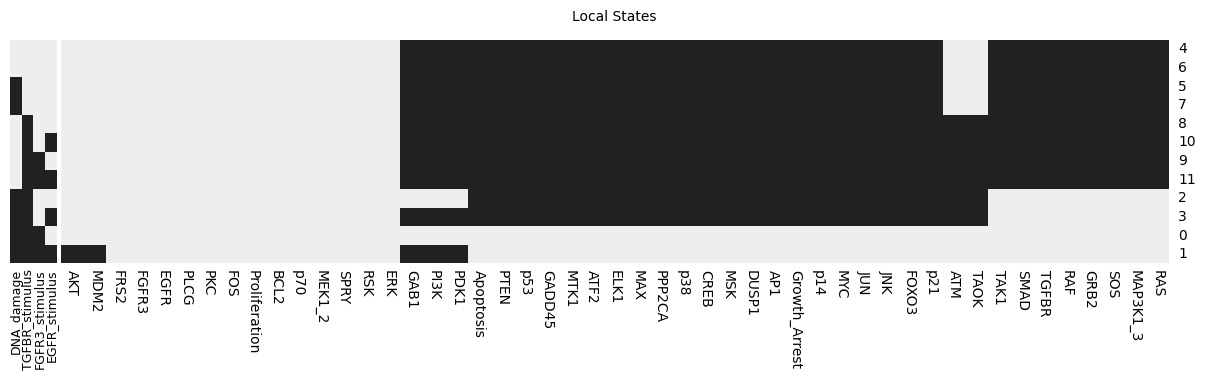

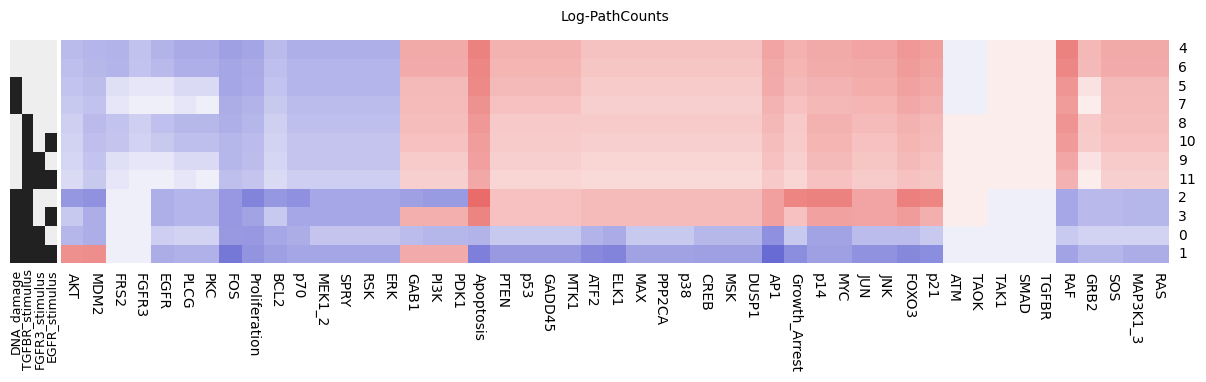

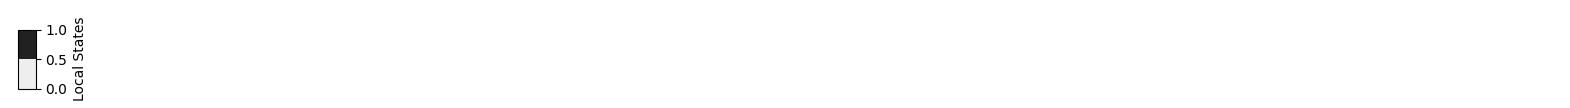

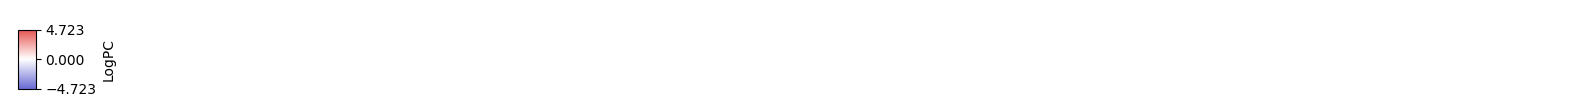

In [15]:
#Plot Report
sim_sum6 = simmulation_summary(model, pc)
display(sim_sum6.style.hide(axis = "index"))
with contextlib.redirect_stdout(io.StringIO()):
    plt.figure(figsize=(15, 3)); ls.plot()
    plt.figure(figsize=(15, 3)); paths.plot()
    plt.figure(figsize=(20, 1)); ls.plot_legends()
    plt.figure(figsize=(20, 1)); paths.plot_legends()

<div style="font-size:90%;">

**Figure 6.** Heatmaps showing the Boolean states (top) and the corresponding transduction path counts (bottom), calculated using BooLEVARD, for the stable states reached by the MAPK Cancer Cell Fate Network Boolean Model. The Boolean activation states of the input nodes (*DNA_damage*, *TGFBR_stimulus*, *FGFR3_stimulus*, *EGFR_stimulus*) that drive each stable state are shown to the left of both heatmaps (black = ON, white = OFF). Path counts are shown on a signed logarithmic scale (Log₄ of the number of activating or inhibitory paths). Red indicates a high number of activating paths toward a node; blue indicates inhibitory paths. Rows (stable states) and columns (nodes) have been clustered using Euclidean distance to highlight patterns across conditions and model components.

</div>

<h4 style="margin-top: 0px; margin-bottom: 2px;" id="section-4"><b>4.- Simulation performance</b></h4>
<p>

In this section, we evaluate the computational performance and scalability of BooLEVARD across the Boolean model set analyzed in **Section 3**. Specifically, we analyze how the average simulation time per stable state relates to the structural complexity of the model, quantified by the average number of retrieved paths per stable state. 

</p>

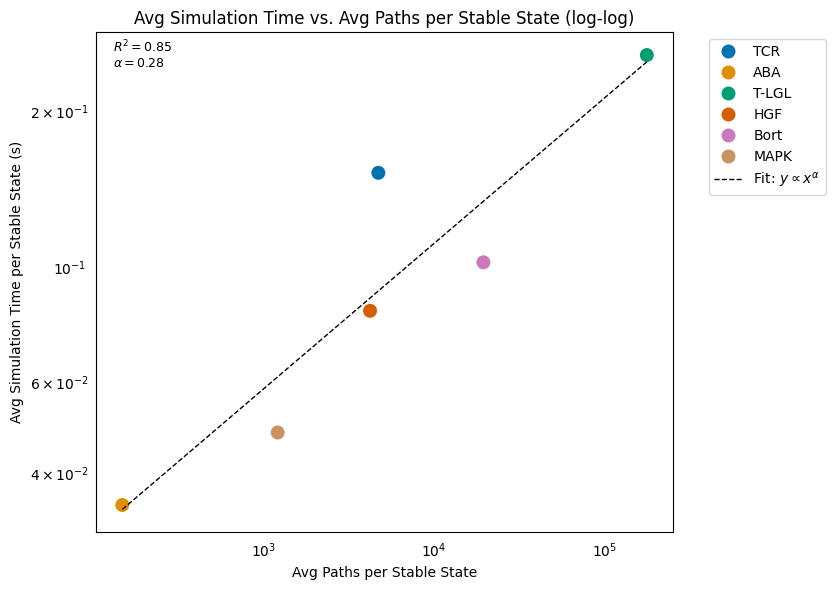

In [16]:
# Plotting average simulation time vs. average paths per stable state for all models
# Combine simulation summaries
sim_sum1["Model"] = "TCR"; sim_sum2["Model"] = "ABA"; sim_sum3["Model"] = "T-LGL"; sim_sum4["Model"] = "HGF"; sim_sum5["Model"] = "Bort"; sim_sum6["Model"] = "MAPK"
sim_sum = pd.concat([sim_sum1, sim_sum2, sim_sum3, sim_sum4, sim_sum5, sim_sum6], ignore_index=True)
sim_sum["Avg sim time per stable state"] = sim_sum["Simulation time (s)"] / sim_sum["Stable states"]
sim_sum["Avg paths per stable state"] = sim_sum["Paths"] / sim_sum["Stable states"]

# Retrieve average simulation time and paths per stable state for each of the models (representation purposes)
x = sim_sum["Avg paths per stable state"]
y = sim_sum["Avg sim time per stable state"]

# Perform a log-transformation and fit a linear model
logx = np.log10(x)
logy = np.log10(y)
slope, intercept = np.polyfit(logx, logy, 1)

# Calculate R-squared value
y_pred_log = np.polyval([slope, intercept], logx)
r2 = r2_score(logy, y_pred_log)

# Generate fitted line for log-log plot
x_fit = np.logspace(np.log10(x.min()), np.log10(x.max()), 100)
y_fit = 10**(intercept + slope * np.log10(x_fit))

# Plot the results
plt.figure(figsize=(8.5, 6))
ax = sb.scatterplot(data=sim_sum, x="Avg paths per stable state", y="Avg sim time per stable state", hue="Model", palette="colorblind", s=120, edgecolor="white")
plt.plot(x_fit, y_fit, "--k", label = r"Fit: $y \propto x^{\alpha}$", linewidth = 1)
plt.text(0.03, 0.93, f"$R^2 = {r2:.2f}$\n$\\alpha = {slope:.2f}$", transform=ax.transAxes, fontsize=9)
ax.set_xscale("log"); ax.set_yscale("log")
ax.tick_params(axis = "both", which = "both", bottom = False, top = False, left = False, right = False)

plt.title("Avg Simulation Time vs. Avg Paths per Stable State (log-log)")
plt.xlabel("Avg Paths per Stable State")
plt.ylabel("Avg Simulation Time per Stable State (s)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<div style="font-size:90%;">

**Figure 7.** Relationship between average simulation time per stable state and average number of paths per stable state for the six Boolean models analyzed with BooLEVARD. Both axes are in logarithmic scale, revealing a sublinear power-law scaling (dashed line) with an exponent $\alpha \approx 0.28$ and $R^2 = 0.84$. 

</div>

For the Boolean models analyzed here, the average simulation time per stable state increases as the number of paths per stable state increases, following a power law with an exponent of about 0.28. This means that the simulation time grows more slowly than the number of paths. For example, if the number of paths increases by a factor of 10, the simulation time increased by roughly a factor of 2 (since $10^{0.28} \approx 2$). While this indicates some efficiency in handling increased complexity, simulation time will still grow as models become larger and more connected. This relationship provides a quantitative basis for understanding BooLEVARD’s performance on these types of biological Boolean models.

